In [1]:
%load_ext autoreload
%autoreload 2

In [152]:
import torch
import yaml
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt

from src.hillshpaeDataModule import MySimCLRTrainDataTransform
from simCLR import *
from src import *

In [3]:
config_path = 'configs/simclr_hill.yaml'

with open(config_path) as f:
    config = yaml.safe_load(f)

In [47]:
config['exp_parmas']['batch_size'] = 10
datamodule = datamodule_model[config['exp_parmas']['dataset']](**config['exp_parmas'])

untrained_model =simclr_model[config['model_params']['name']](**config['model_params'], num_samples=datamodule.train_num)
model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=datamodule.train_num)

# checkpoint load
checkpoint_path = 'logs/SimCLR_Hill/version_4/checkpoints/epoch=499.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])


In [92]:
train_datalaoder = datamodule.train_dataloader()
train_datalaoder.num_workers=0

test_train_data, _ = next(iter(train_datalaoder))

num_data = test_train_data[0].size()[0]
labels = np.array([*np.arange(num_data), *np.arange(num_data)]).reshape(-1,1)

In [155]:
# valid set에다가 train agumentation 적용
valid_dataset = datasets.ImageFolder(root=datamodule.data_path,
                                    transform=MySimCLRTrainDataTransform(datamodule.img_size))
num_train = len(valid_dataset)
indices = list(range(num_train))
split = int(np.floor(datamodule.test_ratio * num_train))
val_idx = indices[:split]
val_sampler = SubsetRandomSampler(val_idx)
valid_dataloader = DataLoader(valid_dataset,
                        num_workers=0,
                        batch_size= 144,
                        sampler=val_sampler,
                        drop_last=True)

In [156]:
test_valid_data, _ = next(iter(valid_dataloader))

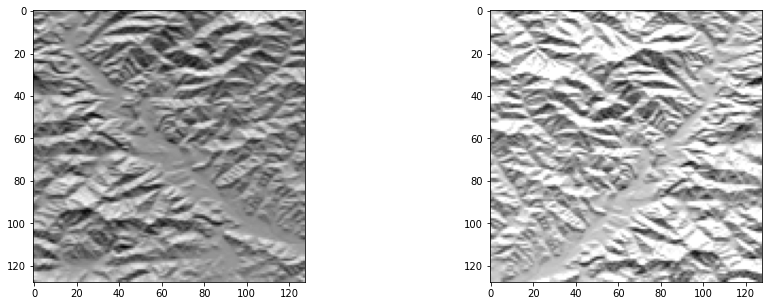

In [121]:
#test_train_data
fig_num = 1

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(test_train_data[0][fig_num][0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(test_train_data[1][fig_num][0], cmap='gray')
plt.show()

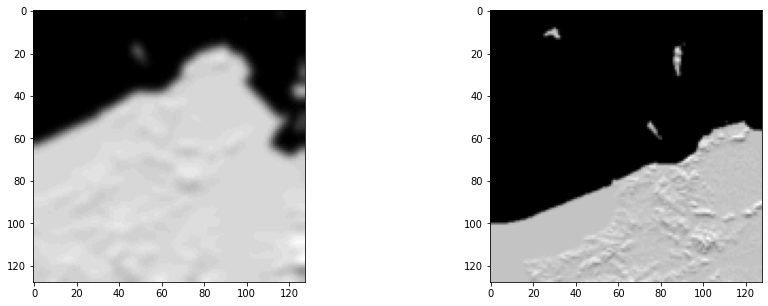

In [157]:
#new_valid_data
fig_num = 1

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(test_valid_data[0][fig_num][0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(test_valid_data[1][fig_num][0], cmap='gray')
plt.show()

In [158]:
select_data = test_valid_data

In [162]:
# Untaining
untrain_fst_latent = untrained_model.forward(select_data[0])
untrain_snd_latent = untrained_model.forward(select_data[1])

untrain_fst_projection = untrained_model.Projection(untrain_fst_latent)
untrain_snd_projection = untrained_model.Projection(untrain_snd_latent)

In [160]:
#train
fst_latent = model.forward(select_data[0])
snd_latent = model.forward(select_data[1])

fst_projection = model.Projection(fst_latent)
snd_projection = model.Projection(snd_latent)

print('size of latent : {}, {}'.format(fst_latent.size(), snd_latent.size()))
print('size of projection : {}, {}'.format(fst_projection.size(), snd_projection.size()))

size of latent : torch.Size([144, 512, 4, 4]), torch.Size([144, 512, 4, 4])
size of projection : torch.Size([144, 32]), torch.Size([144, 32])


## C.O.V of Projection

In [34]:
import seaborn as sns

torch.Size([288, 32])


<AxesSubplot:>

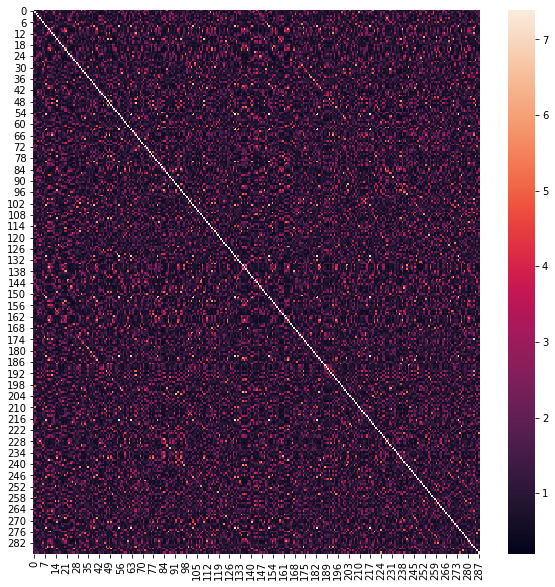

In [161]:
# train
cat_projection = torch.cat([fst_projection, snd_projection], dim=0)
print(cat_projection.size())

cov = torch.mm(cat_projection, cat_projection.t().contiguous())
sim = torch.exp(cov / checkpoint['hyper_parameters']['loss_temperature'])

plt.subplots(figsize=(10,10))
sns.heatmap(sim.detach().numpy())

<AxesSubplot:>

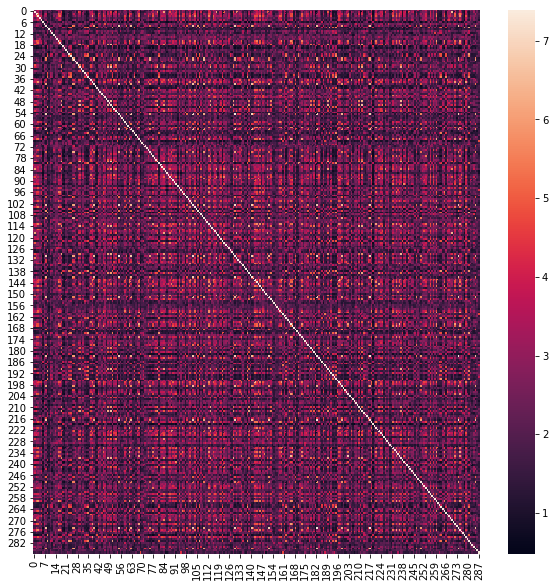

In [163]:
# Untrain
untrain_cat_projection = torch.cat([untrain_fst_projection, untrain_snd_projection], dim=0)

untrain_cov = torch.mm(untrain_cat_projection, untrain_cat_projection.t().contiguous())
untrain_sim = torch.exp(untrain_cov / checkpoint['hyper_parameters']['loss_temperature'])

plt.subplots(figsize=(10,10))
sns.heatmap(untrain_sim.detach().numpy())

"올..."

## PCA

In [97]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [108]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cat_projection.detach().numpy())

In [109]:
pca.explained_variance_ratio_

array([0.23444013, 0.18139815], dtype=float32)

In [110]:
pca_result_pd = pd.DataFrame(np.concatenate([pca_result, labels], axis=-1), columns=['dim1', 'dim2', 'y'])

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

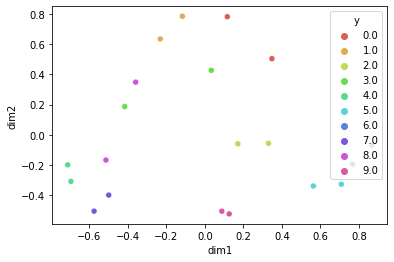

In [111]:
sns.scatterplot(x='dim1', y='dim2', hue='y', data=pca_result_pd, palette=sns.color_palette('hls', 10))

## t-SNE

In [122]:
?TSNE

In [127]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(cat_projection.detach().numpy())

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.019424
[t-SNE] KL divergence after 300 iterations: 0.498996


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

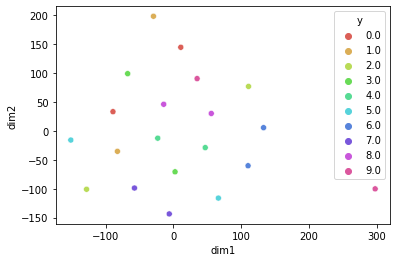

In [128]:
tsne_result_pd = pd.DataFrame(np.concatenate([tsne_results, labels], axis=-1), columns=['dim1', 'dim2', 'y'])
sns.scatterplot(x='dim1', y='dim2', hue='y', data=tsne_result_pd, palette=sns.color_palette('hls', 10))